In [1]:
%matplotlib inline

In [2]:
from calendar import isleap, monthrange

import xarray as xr
import pandas as pd
import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import seaborn as sns

from shapely.geometry.polygon import LinearRing

date_range = slice('1991', '1999')
re = 6.37122e6
sec_per_day = 86400
m3_per_kg = 1000.
km3_per_m3 = 1000. ** 3

colors = dict(zip(['D2009', '$RASM_{CONTROL}$', 'CORE.v2', 'Bamber'], ["#95a5a6", "#34495e", "#2ecc71", "#3498db"]))

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2,)
plt.rcParams.update({'mathtext.default':  'regular' })


In [3]:
# load streamflow datasets
sf_data = {}
sf_data['RASM'] = xr.open_dataset('../../../data/processed/R1010RBRbaaa01a/rof/monthly_mean_timeseries/R1010RBRbaaa01a.rvic.hmm.197909-201412.nc').rename({'ny': 'y', 'nx': 'x'})
sf_data['CORE.v2'] = xr.open_dataset('../../../data/compare/core2/timeseries/wr50a_runoff.daitren.iaf.1948-2007.nc').rename({'Time': 'time'})
# sf_data['Bamber'] = xr.open_dataset('../../../data/compare/core2/timeseries/wr50a_runoff.daitren.iaf.1948-2007.nc')
sf_data['D2009'] = xr.open_dataset('../../../data/compare/dai_trenberth_river/coastal-stns-Vol-monthly.updated-oct2007.nc', decode_times=False)
sf_data['D2009']['time'] = pd.date_range(start='1900-01-01', end='2006-12-31', freq='MS')

domain = xr.open_dataset('../../../data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.130607.nc').rename({'ni': 'x', 'nj': 'y'})
domain['area'] *= re * re
domain['area'] = domain['area'].rename({'doma_ny': 'y', 'doma_nx': 'x'})
domain = domain.drop(('doma_nx', 'doma_ny', ), )
masks = xr.open_dataset('../../../data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc') 


In [4]:
sf_data['RASM'].time.values -= np.timedelta64(1,'D')

In [5]:
shapes = {}
shapes['greenland'] = [(4.218878509029318, 84.00570747196312), (-82.41325334171816, 84.482955058785), (-49.35927043680205, 58.53784646407258), (-40.50563783751677, 58.5504355636692), (4.218878509029318, 84.00570747196312)]
shapes['shelf'] = [(113.7366529006488, 78.03080727626906), (112.2718112672456, 70.18525638019177), (177.7978257335182, 62.06397064307408), (189.8743994667148, 68.2879161699658), (113.7366529006488, 78.03080727626906)]
shapes['canada'] = [(-121.7031868342398, 67.7215741706094), (-126.5650545731124, 74.4075477493822), (-171.2973325321617, 70.14396352414349), (-161.3230859583278, 64.4297855696157), (-121.7031868342398, 67.7215741706094)]
shapes['kara_barrents'] = [(36.06614093875805, 70.4126608318343), (53.92299694433034, 61.76281380910994), (110.3253911335403, 68.93837059743467), (112.5070729419679, 79.13748043666854), (36.06614093875805, 70.4126608318343)]

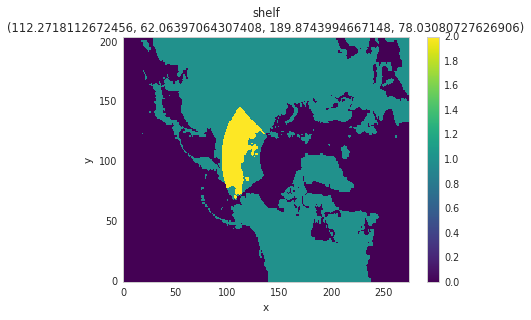

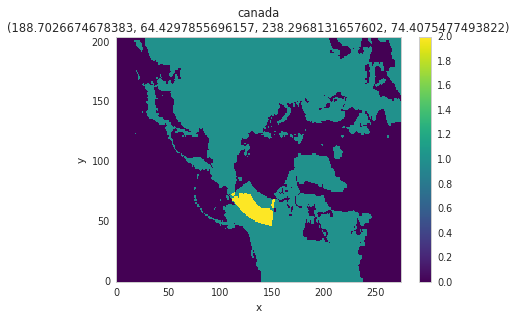

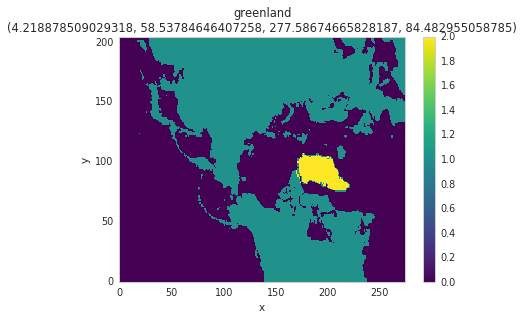

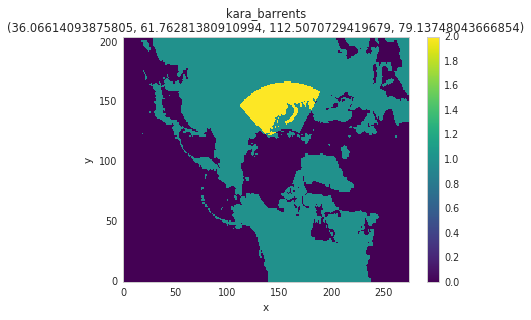

In [6]:
regions = {}
bounds = {}

for key, s in shapes.items():
    poly = LinearRing(s)
    x0, y0, x1, y1 = poly.bounds
    bounds[key] = poly.bounds
    if x0 < 0:
        x0 += 360
    if x1 < 0:
        x1 += 360
        
    if x1 < x0:
        x1, x0 = x0, x1
        
        regions[key] = (~((domain.xc > x0) & (domain.xc < x1)) &
                        (domain.yc > y0) & (domain.yc < y1))
    else:
        regions[key] = ((domain.xc > x0) & (domain.xc < x1) &
                        (domain.yc > y0) & (domain.yc < y1))
        
    if key == 'greenland':
        regions[key] = masks['mask_greenland_island']
    
    
    plt.figure()
    (regions[key] + domain.mask).plot()
    plt.title(key + '\n' + str((x0, y0, x1, y1)))
    

In [7]:
def dpm_from_time_var(time_var, calendar='standard'):
    '''return a data array with the number of days per month'''
    if calendar.lower() in ['standard']:
        def dpm_from_index(index):
            return np.array([monthrange(y, m)[1] for y, m in zip(index.year, index.month)])
    else:
        def dpm_from_index(index):
            from rasmlib.calendar import dpm
            return np.array([dpm[calendar.lower()][m] for m in index.month])

        
    if isinstance(time_var, xr.DataArray):
        dpm = xr.DataArray(dpm_from_index(time_var.indexes['time']),
                           coords=time_var.coords)
    elif isinstance(time_var, pd.Index):
        dpm = pd.Series(dpm_from_index(time_var), index=time_var)
        
        
    return dpm


def get_rasm_or_core2_data(da, mask, drange=date_range):
    da = da.sel(time=drange).where(mask)
    da_vol = (da * domain['area']
              * sec_per_day
              * dpm_from_time_var(da['time'], calendar='365_day')
              / m3_per_kg
              / km3_per_m3).sum(dim=('x', 'y'))
    s_group = da_vol.to_series().groupby(lambda x: x.month)
    return pd.DataFrame({'mean': s_group.mean(),
                         'std': s_group.std()})

def get_d2009_data(ds, bounds, drange=date_range):

    x0, y0, x1, y1 = bounds
    
    da = ds['FLOW'].sel(time=drange)

    if x1 < x0:
        x1, x0 = x0, x1

        inds = (~((ds['lon'] > x0) & (ds['lon'] < x1)) &
                (ds['lat'] > y0) & (ds['lat'] < y1))
    else:
        inds = ((ds['lon'] > x0) & (ds['lon'] < x1) &
                (ds['lat'] > y0) & (ds['lat'] < y1))
        
    da_vol = da.sel(station=inds) * dpm_from_time_var(ds['time']) * 86400 / km3_per_m3
    
    s_group = da_vol.sum(dim='station').to_series().groupby(lambda x: x.month)
        
    return pd.DataFrame({'mean': s_group.mean(),
                         'std': s_group.std()})




In [8]:
# load bamber data
bamber = xr.open_dataset('../data/processed_bamber_fwf_data.nc')
s_bamber = bamber['fwf'].sum(dim=('x', 'y')).to_series()

In [9]:
titles = {'greenland': 'Greenland Coast',
          'canada': 'NW Canada and Alaska Coast',
          'shelf': 'Siberian Shelf Coast',
          'kara_barrents' : 'Kara and Barrents Seas Coast'}

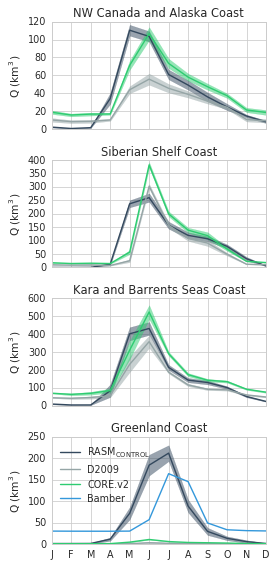

In [11]:
fig, axes = plt.subplots(nrows=len(regions), sharex=True, figsize=(4, 8))

for i, key in enumerate(['canada', 'shelf', 'kara_barrents', 'greenland']):

    ax = axes[i]
    
    # Get data
    df_c2 = get_rasm_or_core2_data(sf_data['CORE.v2']['runoff'],
                                   regions[key])
    df_rasm = get_rasm_or_core2_data(sf_data['RASM']['QCHOCNR'],
                                     regions[key])
    df_d2009 = get_d2009_data(sf_data['D2009'], bounds[key])
    
    # add data to plot
    
    df_rasm['mean'].plot(ax=ax, label='$RASM_{CONTROL}$',
                         color=colors['$RASM_{CONTROL}$'])
    ax.fill_between(df_rasm.index,
                    df_rasm['mean'] + df_rasm['std']/2,
                    df_rasm['mean'] - df_rasm['std']/2,
                    color=colors['$RASM_{CONTROL}$'], alpha=0.5)

    df_d2009['mean'].plot(ax=ax, label='D2009', color=colors['D2009'])
    ax.fill_between(df_d2009.index,
                    df_d2009['mean'] + df_d2009['std']/2,
                    df_d2009['mean'] - df_d2009['std']/2,
                    color=colors['D2009'], alpha=0.5)
    
    df_c2['mean'].plot(ax=ax,
                       label='CORE.v2',
                       color=colors['CORE.v2'])
    ax.fill_between(df_c2.index,
                    df_c2['mean'] + df_c2['std']/2,
                    df_c2['mean'] - df_c2['std']/2,
                    color=colors['CORE.v2'], alpha=0.5)
  
    if key == 'greenland':
        s_bamber.plot(ax=ax, label='Bamber',
                      color=colors['Bamber'])
    
    ax.set_ylabel('Q ($km^3$)')
    ax.set_title(titles[key])
    ax.set_xlabel('')
    
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    
axes[-1].legend(loc=2)
    
fig.tight_layout()

fig.savefig('../figs/coastal_hydrographs.png', dpi=300)